#### REPORT

##### Different parameters results analysis

##### Confusion Matrix

##### Feature Importance

##### Training/testing error curves

##### Sklearn classification report

In [12]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn.model_selection import train_test_split

### Preprocessing the data

#### Cutting the dataset so that there is the same amount of fraud and not fraud cases

In [13]:
df = pd.read_csv('../data/card_transdata.csv')

# Get counts of fraud and non-fraud cases
fraud_count = df['fraud'].value_counts()
min_count = fraud_count.min()

# Separate fraud and non-fraud cases
fraud_df = df[df['fraud'] == 1].sample(n=min_count, random_state=42)
non_fraud_df = df[df['fraud'] == 0].sample(n=min_count, random_state=42)

# Combine the balanced datasets
df = pd.concat([fraud_df, non_fraud_df])

# Shuffle the final dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
X = df.drop(columns=["fraud"])
y = df["fraud"]

y = keras.utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

print(X.shape)
print(y.shape)

(174806, 7)
(174806, 2)


### Plotting visualizations fo the input data

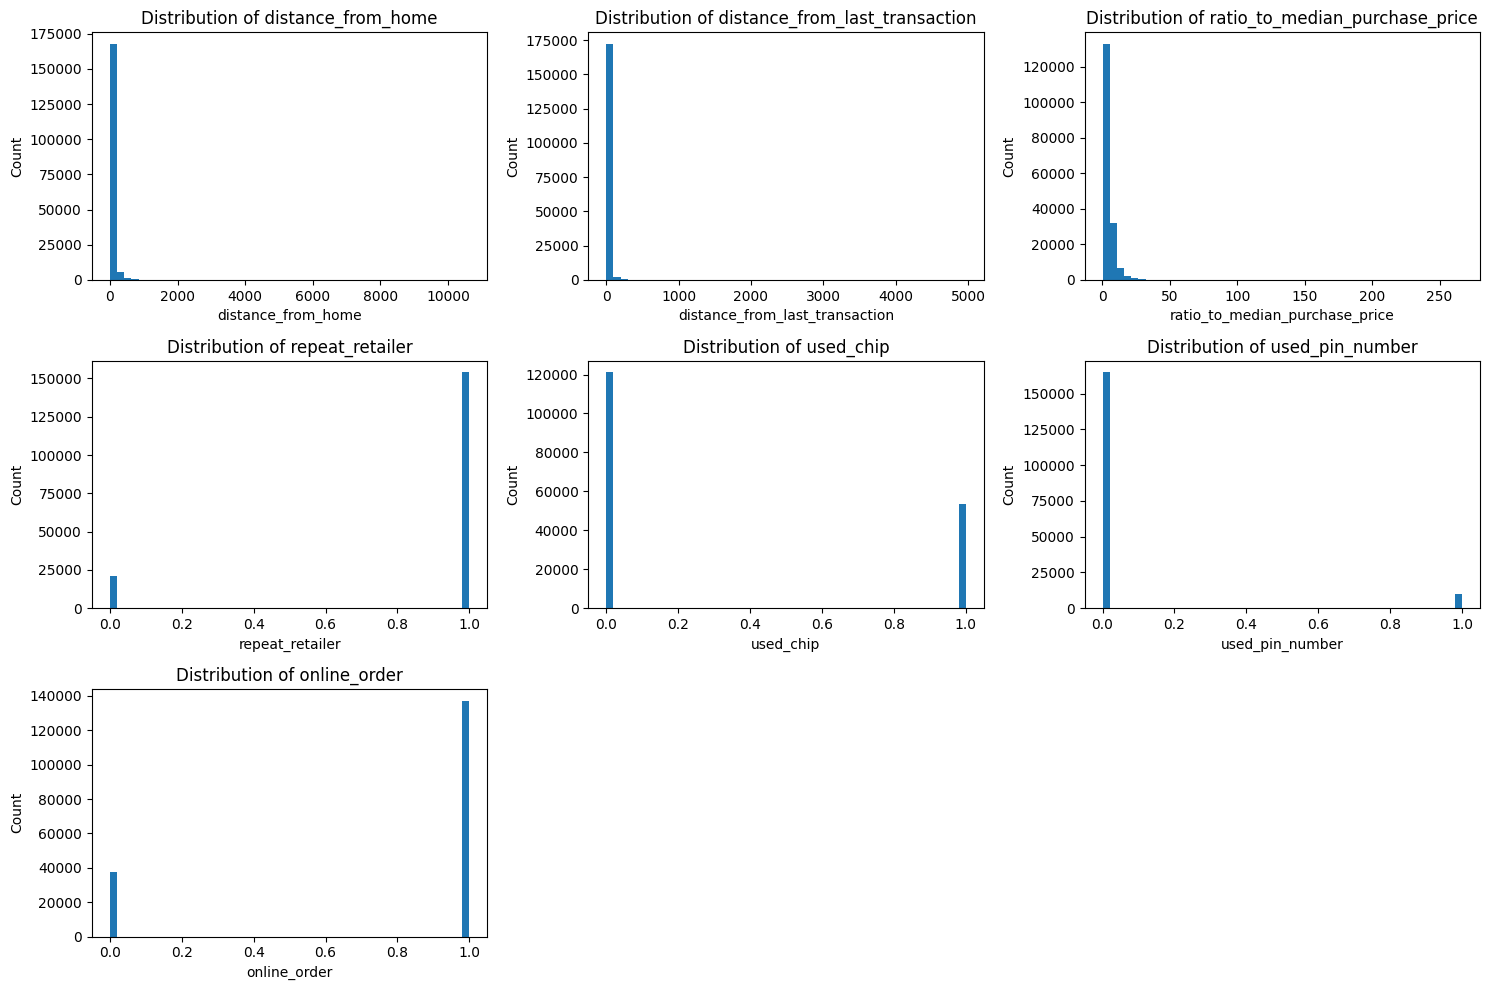

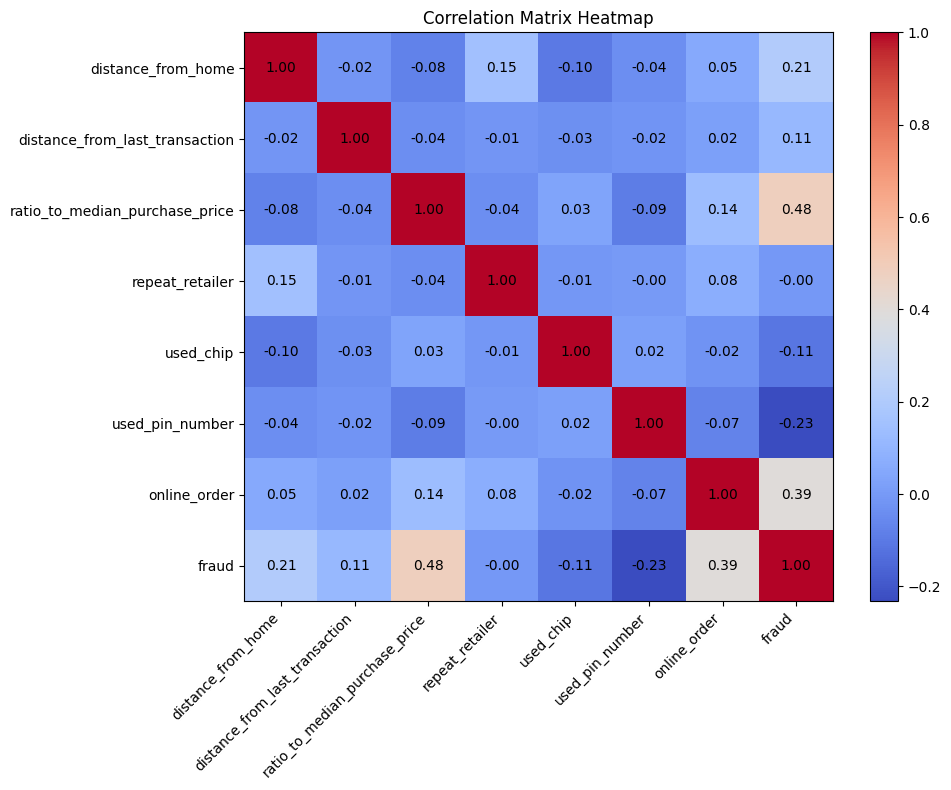

In [15]:
# features distribution
plt.figure(figsize=(15, 10))
for i, column in enumerate(X.columns, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[column], bins=50)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center')
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

In [44]:
# # Apply PCA preprocessing
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# # First standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Apply PCA
# # Keep 95% of the variance
# pca = PCA(n_components=0.95)
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# print("Original number of features:", X_train.shape[1])
# print("Number of features after PCA:", X_train_pca.shape[1])
# print("Explained variance ratio:", sum(pca.explained_variance_ratio_))

# # Update X_train and X_test with PCA transformed data
# X_train = X_train_pca
# X_test = X_test_pca

Original number of features: 7
Number of features after t-SNE: 2


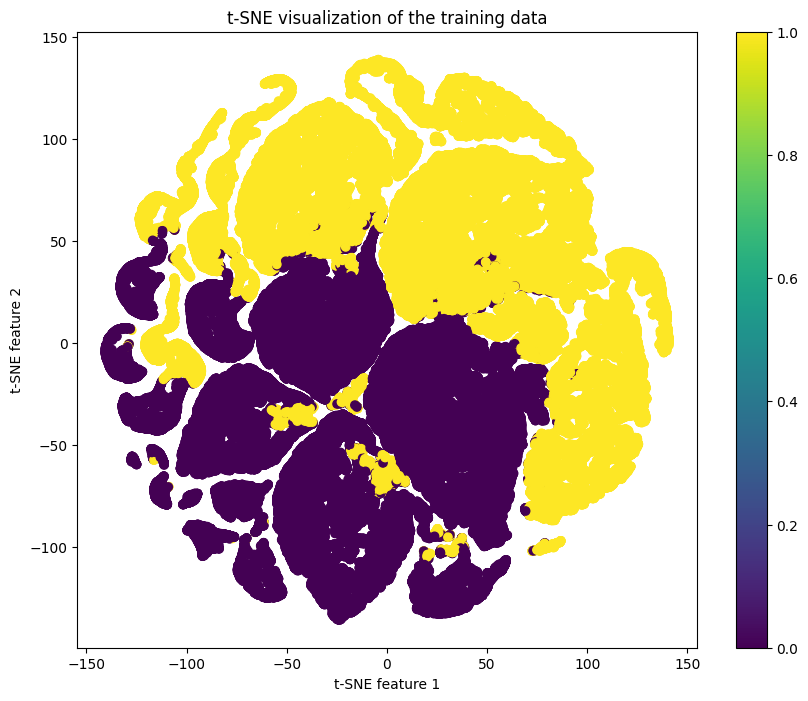

In [45]:
# # Apply t-SNE preprocessing
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler

# # First standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Apply t-SNE
# # Using 2 components for visualization
# tsne = TSNE(n_components=2, random_state=42)
# X_train_tsne = tsne.fit_transform(X_train_scaled)
# X_test_tsne = tsne.fit_transform(X_test_scaled)

# print("Original number of features:", X_train.shape[1])
# print("Number of features after t-SNE:", X_train_tsne.shape[1])

# # Update X_train and X_test with t-SNE transformed data
# X_train = X_train_tsne
# X_test = X_test_tsne

# # Visualize the t-SNE results
# plt.figure(figsize=(10, 8))
# y_train_plot = np.argmax(y_train, axis=1)
# plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train_plot, cmap='viridis')
# plt.colorbar()
# plt.title('t-SNE visualization of the training data')
# plt.xlabel('t-SNE feature 1')
# plt.ylabel('t-SNE feature 2')
# plt.show()

### Creating the model

In [17]:
model = Sequential()

model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(y.shape[1],activation='softmax'))
opt = keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=3, verbose=1, mode='auto', restore_best_weights=True)
model.summary()
history = model.fit(X_train, y_train, validation_split=0.33, verbose=1, epochs=50, callbacks=[monitor])

pred = model.predict(X_test)

pred = np.argmax(pred,axis=1)
y_compare = np.argmax(y_test,axis=1)

c:\Users\rrang\Desktop\codes\course_work\INM701\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 642 (2.51 KB)

 Trainable params: 642 (2.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8956 - loss: 0.0894 - val_accuracy: 0.9586 - val_loss: 0.0362
Epoch 2/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9624 - loss: 0.0321 - val_accuracy: 0.9768 - val_loss: 0.0215
Epoch 3/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9684 - loss: 0.0270 - val_accuracy: 0.9798 - val_loss: 0.0173
Epoch 4/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9696 - loss: 0.0267 - val_accuracy: 0.9680 - val_loss: 0.0270
Epoch 5/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9764 - loss: 0.0203 - val_accuracy: 0.9822 - val_loss: 0.0151
Epoch 6/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9768 - loss: 0.0199 - val_accuracy: 0.9821 - val_loss: 0.0150
Epoch 7/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9759 - loss: 0.0208 - val_accuracy: 0.9759 - val_loss: 0.0214
Epoch 8/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9812 - loss: 0.0166 - 

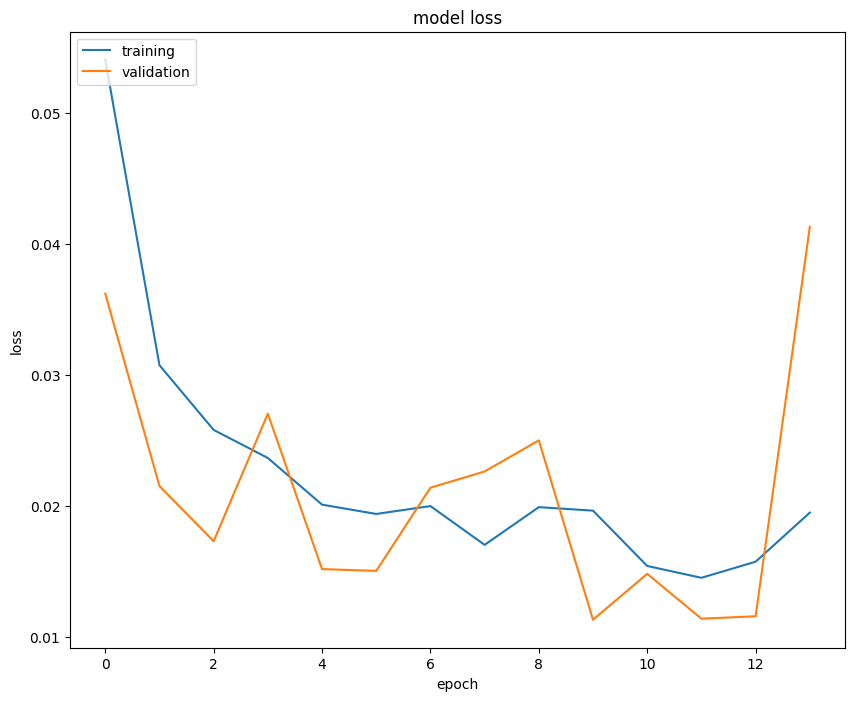

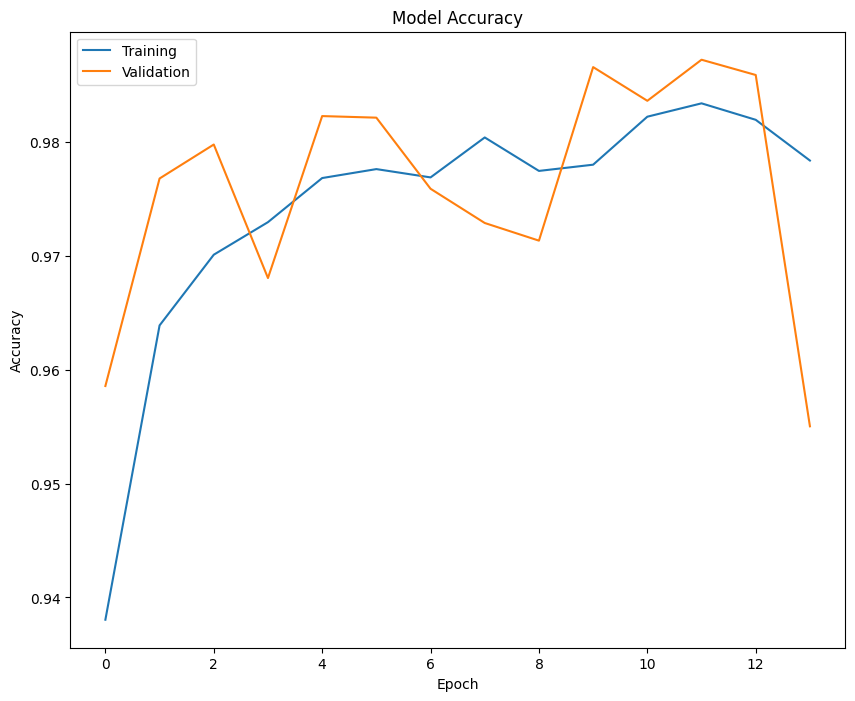

In [21]:
# Plot training loss curve
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# Plot training accuracy curve
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [22]:
score = metrics.accuracy_score(y_compare, pred)
precision = metrics.precision_score(y_compare, pred)
recall = metrics.recall_score(y_compare, pred)
f1 = metrics.f1_score(y_compare, pred)
r2 = metrics.r2_score(y_compare, pred)

print("Accuracy score: {:.2f}".format(score))
print("Precision score: {:.2f}".format(precision))
print("Recall score: {:.2f}".format(recall))
print("F1 score: {:.2f}".format(f1))
print("R2 score: {:.2f}".format(r2))

Accuracy score: 0.98
Precision score: 0.97
Recall score: 1.00
F1 score: 0.98
R2 score: 0.93


### Plotting the confusion matrix of the result

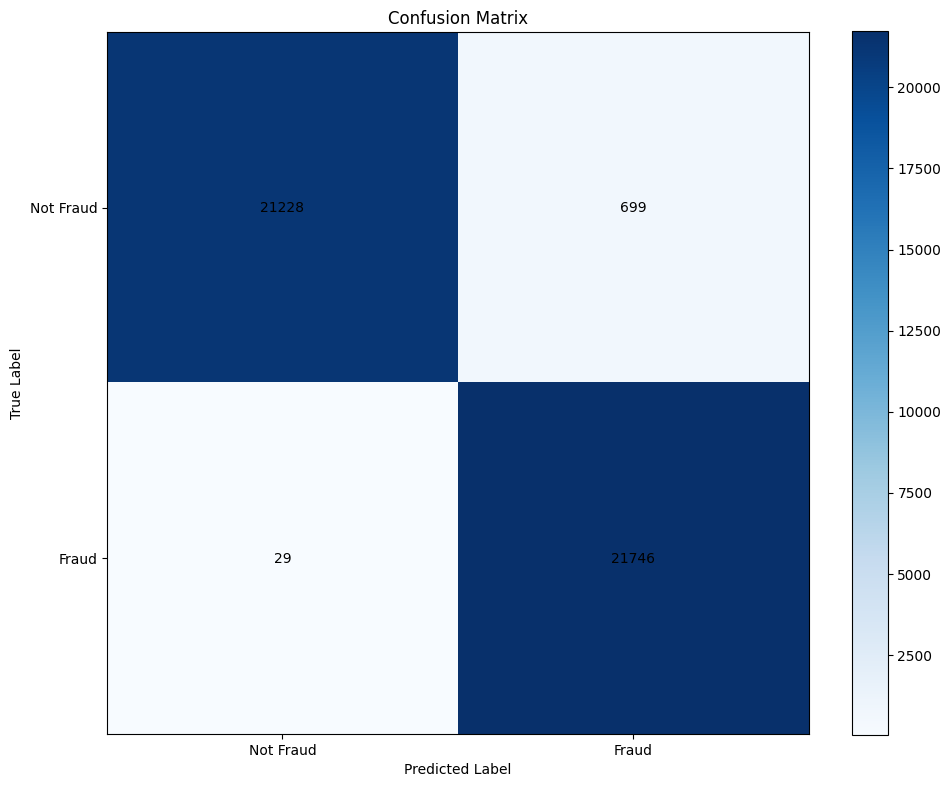

In [20]:
labels = ['Not Fraud', 'Fraud']

plt.figure(figsize=(10, 8))
confusion_mtx = metrics.confusion_matrix(y_compare, pred)
plt.imshow(confusion_mtx, interpolation='nearest', cmap='Blues')
plt.colorbar()

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j, i, str(confusion_mtx[i, j]),
                ha='center', va='center')

plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)

plt.tight_layout()
plt.show()